In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

#set path where to read and write data
data_path = "C:/Users/adiad/Anaconda3/envs/BasicDataScience/Projects/dont_overfit_ii/"

#import data
train_df = pd.read_csv(os.path.join(data_path, "train.csv"), index_col=0)
test_df = pd.read_csv(os.path.join(data_path, "test.csv"), index_col=0)

# Don't Overfit! II - Kaggle Competition

By Chris Raper

## Introduction
The challenge in this competition is to fit the training dataset as well as possible without overfitting it.  The training dataset is 250 rows x 300 features along with 1 target.  The target is binary and all of the features are continuous.  Once trained, a submission will predict the target value for 19,750 observations in the test datatset.  The evaluation metric will be ROC AUC (Receiver Operatore Characteristic Area Under Curve).

I chose this competition because ROC AUC was utilized in my Titanic competition and I wanted to understand it better.  Also, for my Data Analytics capstone project in 2018, overfitting was a major focus of my work.  In that project AICc was the information criterion selected to judge overfitting.  This new competition will give the opportunity to extend my previous studies.

## Examination of ROC AUC
ROC is a curve produced by plotting the False Positive rate on the x-axis against the True Positive rate on the Y-axis.  The curve is generated for a sample dataset where a continuous or discrete valued feature is used to predict the target binary classification.  The ROC curve takes on various (x, y) coordinates as the threshold for classification is adjusted.  The curve is not smooth, but abuptly changes slope each time the threshold change causes a classification to change.  It represents all of the possible confusion matices which a sample dataset may produce, depending on the classification threshold.  A point above the y = x line can be viewed as an outcome that is better than random guessing.

AUC enables comparison of ROC curves.  Having greater values mean the models are better at discerning the classification.

## EDA
The data will be explored in the following code cells and if a need for cleaning is discovered, it will also be accomplished here.

In [3]:
X_train_df = train_df.drop("target", axis=1)
all_feature_df = X_train_df.append(test_df)
all_feature_na_count = all_feature_df.isnull().sum().sum()
y_train = train_df["target"]
taregt_na_count = y_train.isnull().sum()
print("Number of NA occurrences in all of the data provided:", all_feature_na_count)
print("Number of NA occurrences in target data provided:", taregt_na_count)

Number of NA occurrences in all of the data provided: 0
Number of NA occurrences in target data provided: 0


The above results show that the data provided is complete.

In [4]:
all_feature_max, all_feature_min = all_feature_df.max().max(), all_feature_df.min().min()
print("The feature min and max values for the entire dataset is respectively:",
    all_feature_min, all_feature_max)
print("The target values for the entire dataset are binary because the unique",
    "values are:", y_train.unique())

The feature min and max values for the entire dataset is respectively: -5.222 5.125
The target values for the entire dataset are binary because the unique values are: [1. 0.]


The results above show the feature values approximately span \[-5.25, 5.25\] and the target values are binary.

In [5]:
print("The mean target value is:", y_train.mean())

The mean target value is: 0.64


The training data shows some bias toward 1 (negative skew).  All that remains in EDA is to llok for dimensionality reduction.

In [6]:
feature_stds = np.sort(X_train_df.std())
print("Smallest standard deviation value features:", feature_stds[:3])

feature_means = np.sort(X_train_df.mean())
print("Smallest and largest mean value features are respectivey:", feature_means[0], feature_means[-1])

Smallest standard deviation value features: [0.88941567 0.89631831 0.89763422]
Smallest and largest mean value features are respectivey: -0.200064 0.18962799999999988


The result above implies that there aren't any features with low information as measred by variance.  The smallest standard deviation amoung all features is 0.89, which corresponds with 8% of the feature domain.  Next, Principal Component Analysis will be applied to see whether the data can be projected to lower dimensional space.

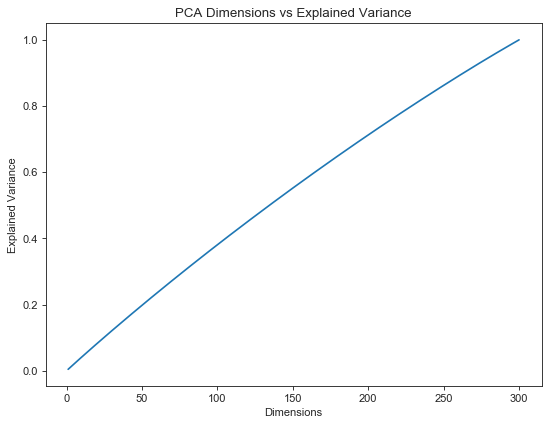

In [7]:
from sklearn.decomposition import PCA
pca = PCA().fit(all_feature_df)
evr = np.cumsum(pca.explained_variance_ratio_)

#plot explained variance vs dimensions
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
sns.set_style("ticks")
plt.plot(np.linspace(1,len(evr),len(evr)), evr)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("PCA Dimensions vs Explained Variance")
plt.savefig(os.path.join(data_path, "Feature-PCA.png"), dpi=100)
plt.show()

The plot above shows that the dataset essentially doesn't have principal components.  If it did, the curve would start with a large slope then decrease monotonically.  Since it is a straight line, all dimensions must have similar variance.  Therefore dimension reduction is unlikely to preserve most information in the dataset.

The next step in EDA will be to examine how some of the feature observations are distributed.

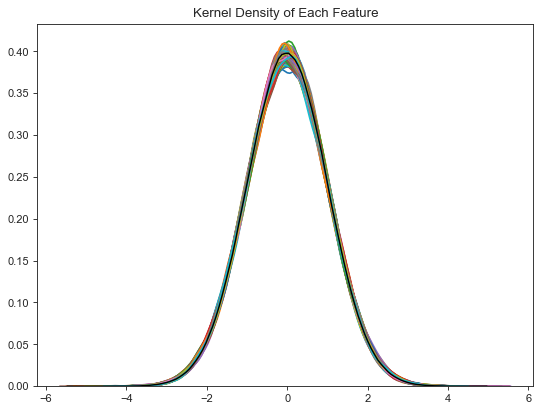

In [8]:
import random
import matplotlib.mlab as mlab

cols_ls = [int(x) for x in np.linspace(0,299,300)]
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
for col in cols_ls:
    sns.kdeplot(np.array(all_feature_df.iloc[:,col]))
norm_feature = np.random.normal(all_feature_df.stack().mean(), all_feature_df.stack().std(), int(2e6))
sns.kdeplot(norm_feature, color="black", linewidth=1.3)
plt.title("Kernel Density of Each Feature")
plt.savefig(os.path.join(data_path, "Feature-Kernel-Densities.png"), dpi=100)
plt.show()

The plot above shows all features are nearly identical in distribution.  The black line overlaid is a normal distribution with the population mean and standard deviation of all features.  From this it is safe to conclude that all features are normally distributed.  This could suggest a Gaussian naive bayes classifier would perform well.

The last EDA step will be to check whether any of the features is highly correlated with another.


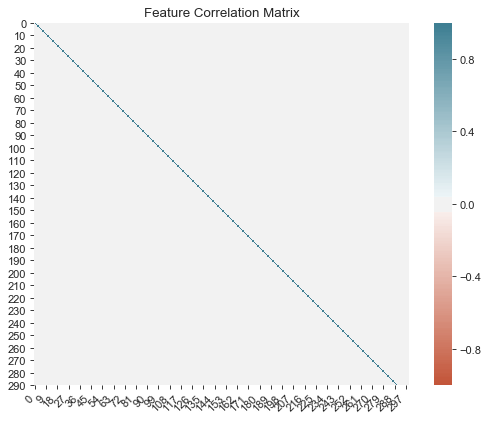

In [9]:
feature_corr = all_feature_df.corr()
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
ax = sns.heatmap(feature_corr, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.title("Feature Correlation Matrix")
plt.savefig(os.path.join(data_path, "Feature-Correlations.png"), dpi=100)
plt.show()

The correlation matrix shown above reveals that no two features have significant correlation, therefore the variables will be treated as independent, meaning that there are no redundant features that can be dropped.

## Modeling
First various classification techniques will be applied, including logistic regression, K nearest neighbors, a few types of support vector machine, decision tree and stochastic gradient descent.  Hyperparameters will be tuned in most of these models.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import RandomizedSearchCV, cross_validate

#logistic regression
log_reg_clf = LogisticRegression(solver="lbfgs")
log_reg_cv = cross_validate(log_reg_clf, X_train_df, y_train, scoring="roc_auc", cv=5, return_estimator=True)
score_df = pd.DataFrame()
log_reg = log_reg_clf.fit(X_train_df, y_train)

#collect cross validation scores in dataframe
score_df["Alg Name"] = ["Logistic Regression"]
score_df["Mean Score"] = [log_reg_cv["test_score"].mean()]

#linear SVC
lin_svc_clf = LinearSVC()
lin_svc_cv = cross_validate(lin_svc_clf, X_train_df, y_train, scoring="roc_auc", cv=5, return_estimator=True)

#function to add new cross validation score to dataframe
def add_score(score_df, new_scores, alg_name):
    new_score_df = pd.DataFrame()
    new_score_df["Alg Name"] = [alg_name]
    if isinstance(new_scores, dict):
        new_score_df["Mean Score"] = [np.mean(new_scores.get("test_score"))]
    else:
        new_score_df["Mean Score"] = [new_scores]
    score_df = pd.concat([score_df, new_score_df], axis=0)
    return score_df

score_df = add_score(score_df, lin_svc_cv, "SVC - Linear Kernel")
lin_svc = lin_svc_clf.fit(X_train_df, y_train)

#polynomial SVC
poly_svc_clf = SVC(kernel="poly", degree=3, gamma="auto")
poly_svc_cv = cross_validate(poly_svc_clf, X_train_df, y_train, scoring="roc_auc", cv=5, return_estimator=True)
score_df = add_score(score_df, poly_svc_cv, "SVC - Poly. Kernel")
poly_svc = poly_svc_clf.fit(X_train_df, y_train)

In [11]:
from sklearn.model_selection import RandomizedSearchCV

#Gaussian RBF
rbf_params_grid = {
    "C": np.logspace(1e3,1e7,100),
    "gamma": np.linspace(1e-5, 1e-4, 1000)
}
rbf_svc_clf = SVC(kernel="rbf", probability=True)
rbf_svc = RandomizedSearchCV(rbf_svc_clf, param_distributions=rbf_params_grid, n_iter=1000, cv = 5, verbose=2, random_state=123, n_jobs = -1, scoring="roc_auc")
rbf_svc.fit(X_train_df, y_train)
scores = rbf_svc.cv_results_
score_df = add_score(score_df, rbf_svc.best_score_, "SVC - RBF Kernel")

C:\Users\adiad\Anaconda3\envs\BasicDataScience\lib\site-packages\numpy\core\function_base.py:279: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.6min finished


In [12]:
print(rbf_svc.best_params_)

{'gamma': 1.2702702702702704e-05, 'C': inf}


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#knn
knn_params_grid = {
    "n_neighbors": [int(x) for x in np.linspace(1, 10, 10)],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}
knn_clf = KNeighborsClassifier()
knn = GridSearchCV(knn_clf, param_grid=knn_params_grid, cv = 5, verbose=2, n_jobs = -1, scoring="roc_auc")
knn.fit(X_train_df, y_train)
scores = knn.cv_results_
score_df = add_score(score_df, knn.best_score_, "K-Nearest Neighbors")

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.2s finished


In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

#decison tree
tree_params_grid = {
    "min_impurity_decrease": np.linspace(.001, 0.01, 20),
    "min_samples_leaf": [int(x) for x in np.linspace(5, 15, 11)]
}
tree_clf = DecisionTreeClassifier(criterion="entropy", presort=True, random_state=123)
tree = GridSearchCV(tree_clf, param_grid=tree_params_grid, cv = 5, verbose=2, n_jobs = -1, scoring="roc_auc")
tree.fit(X_train_df, y_train)
scores = tree.cv_results_
score_df = add_score(score_df, tree.best_score_, "Decision Tree")

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   12.0s finished


{'min_impurity_decrease': 0.005736842105263158, 'min_samples_leaf': 10}


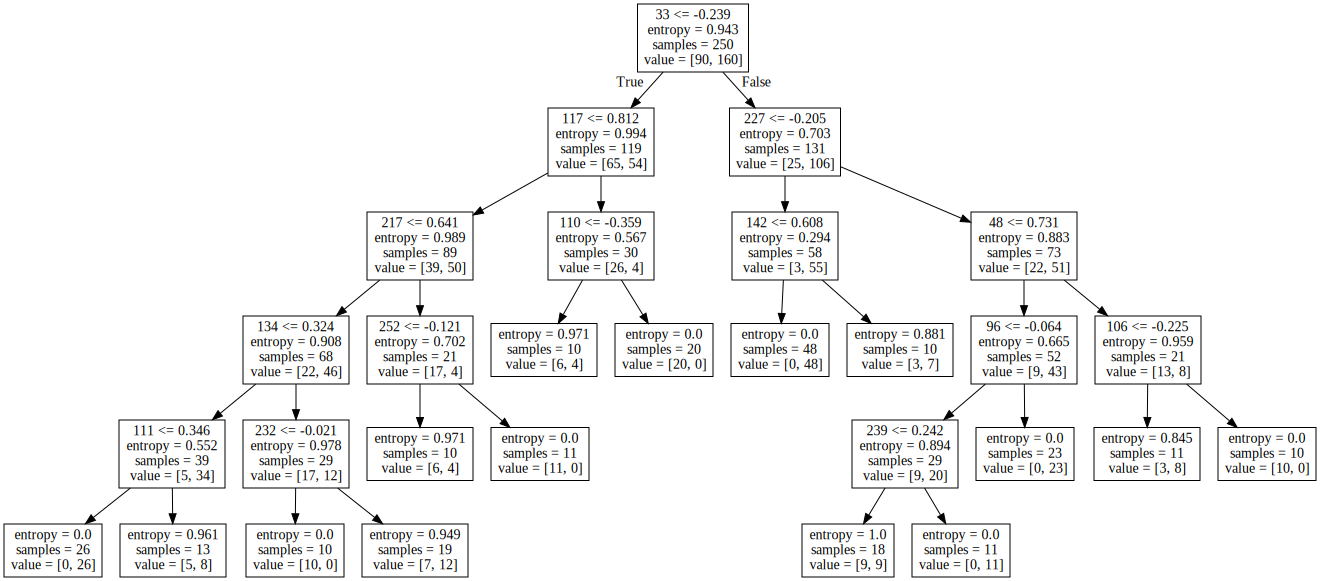

In [15]:
print(tree.best_params_)

#make a graph of the best decision tree
dot_data = export_graphviz(tree.best_estimator_, feature_names=X_train_df.columns, out_file=None)
graph = graphviz.Source(dot_data)
graph.render(filename="DecisionTree", directory=data_path, view=False, format="png")
graph

In [16]:
from sklearn.linear_model import SGDClassifier

#SGD
sgd_params_grid = {
    "loss": ["modified_huber"], #"hinge", "log", "squared_hinge", "perceptron"
    "alpha": np.logspace(1, 100, 11),
    "learning_rate": ["constant", "optimal", "adaptive"],
    "eta0": np.linspace(.1, 10, 11)
}
sgd_clf = SGDClassifier(max_iter=np.ceil(10**6 / len(X_train_df)), random_state=123)
sgd = GridSearchCV(sgd_clf, param_grid=sgd_params_grid, cv = 5, verbose=2, n_jobs = -1, scoring="roc_auc", error_score=0)
sgd.fit(X_train_df, y_train)
scores = tree.cv_results_
score_df = add_score(score_df, sgd.best_score_, "Stocastic Grad. Descent")

Fitting 5 folds for each of 363 candidates, totalling 1815 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1815 out of 1815 | elapsed:    9.0s finished


In [17]:
print(sgd.best_params_)

{'alpha': 10.0, 'eta0': 3.07, 'learning_rate': 'adaptive', 'loss': 'modified_huber'}


In [18]:
from sklearn.naive_bayes import GaussianNB

#Gaussian Naive Bayes
gauss_nb_clf = GaussianNB()
gauss_nb_cv = cross_validate(gauss_nb_clf, X_train_df, y_train, scoring="roc_auc", cv=5, return_estimator=True)
score_df = add_score(score_df, gauss_nb_cv, "Gaussian Naive Bayes")
gauss_nb = gauss_nb_clf.fit(X_train_df, y_train)

In [19]:
score_df.set_index("Alg Name").sort_values("Mean Score", ascending=False)

,Mean Score
Alg Name,
Logistic Regression,0.759028
SVC - RBF Kernel,0.758333
Stocastic Grad. Descent,0.750694
SVC - Linear Kernel,0.744097
Gaussian Naive Bayes,0.697917
SVC - Poly. Kernel,0.678125
K-Nearest Neighbors,0.627431
Decision Tree,0.610069


The table above shows that four out of seven algorithms achieved nearly identical 5 fold mean ROC AUC scores.  Surpisingly, even though all features are normally distributed, the Gaussian Naive Bayes classifier didn't perform well.  Next, ensemble techniques will be applied. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

#random forest
rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(20, 220, num = 11)],
    'min_samples_split':  [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 50, num = 9)]
}

rf_clf = RandomForestClassifier(bootstrap=True, random_state=123)
rf = RandomizedSearchCV(rf_clf, param_distributions=rf_param_grid, n_iter=100, cv = 5, verbose=2, random_state=123, n_jobs = -1, scoring="roc_auc")
rf.fit(X_train_df, y_train)
score_df = add_score(score_df, rf.best_score_, "Ensemble - RF")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


In [21]:
from sklearn.ensemble import AdaBoostClassifier

#ADA Boost
ada_param_grid = {
    "base_estimator__min_impurity_decrease": np.linspace(.035, .045, 11),
    "base_estimator__criterion" : ["gini"], #"entropy"
    "base_estimator__splitter" :   ["random"], #"best"
    "n_estimators": [int(x) for x in np.linspace(180, 200, 11)]
}
ada_tree_clf = DecisionTreeClassifier(random_state=123)
ada_clf = AdaBoostClassifier(base_estimator = ada_tree_clf)
ada = GridSearchCV(ada_clf, param_grid=ada_param_grid, cv = 5, verbose=2, n_jobs = -1, scoring="roc_auc")
ada.fit(X_train_df, y_train)
score_df = add_score(score_df, ada.best_score_, "Ensemble - ADA Boost")

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 605 out of 605 | elapsed:  1.3min finished


In [22]:
from sklearn.ensemble import GradientBoostingClassifier

#Gradient Boosting
gb_param_grid = {
    "learning_rate": np.linspace(0.2, 0.25, 6), 
    "n_estimators": [int(x) for x in np.linspace(260, 300, 5)],
    "min_samples_split": [int(x) for x in np.linspace(2, 5, 4)], 
    "min_samples_leaf": [25, 30, 35, 40],
    "max_features": [5,10,15]
}
grad_boost_clf = GradientBoostingClassifier(max_depth=3, subsample=1, random_state=123)
grad_boost = GridSearchCV(grad_boost_clf, param_grid=gb_param_grid, cv = 5, verbose=2, n_jobs = -1, scoring="roc_auc")
grad_boost.fit(X_train_df, y_train)
score_df = add_score(score_df, grad_boost.best_score_, "Ensemble - Grad Boost")

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  4.4min finished


In [23]:
#list all sklearn classifiers that provide predict_proba, thereby supporting soft voting
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
VotingClassifier
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor


C:\Users\adiad\Anaconda3\envs\BasicDataScience\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\adiad\Anaconda3\envs\BasicDataScience\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [24]:
from sklearn.ensemble import VotingClassifier

def all_perm_combos(vals, n_elements):
    """
    Provides a list of all unique permutations of a sequence.
    
    Keyword arguments:
    vals - A list of possible values
    n_elements - An integer for the number elements in the desired in each sequence
    """
    from itertools import combinations_with_replacement, permutations
    
    #create list of all possible combinations of values
    combos = np.asarray(list(combinations_with_replacement(vals, n_elements)))

    all_perm_combos = [[]]
    for row in range(combos.shape[0]):
        #create all possible permutations of each possible combination
        #but drop permutations which are duplicates (ie [0,0,0] will have 2 duplicates)
        piece_perm_combos = np.unique(list(permutations(combos[row,:])), axis=0)

        #append new unique permutations to array of all permutations
        if row == 0:
            all_perm_combos = piece_perm_combos
        else:
            all_perm_combos = np.vstack((all_perm_combos, piece_perm_combos))
    return all_perm_combos.tolist()


#Voting classifier
voters = [
    ("ada", ada.best_estimator_),
    ("dt", tree.best_estimator_),
    ("gauss nb", gauss_nb),
    ("grad boost", grad_boost.best_estimator_),
    ("knn", knn.best_estimator_),
    ("log reg", log_reg),
    ("rand forest", rf.best_estimator_),
    ("sgd", sgd.best_estimator_),
    ("rbf svc", rbf_svc.best_estimator_)
]
voting_param_grid = {
    "weights": all_perm_combos([0,1], len(voters))[1:]
}
voting_clf = VotingClassifier(voters, voting="soft")
voting = GridSearchCV(voting_clf, param_grid=voting_param_grid, cv = 5, verbose=2, n_jobs = -1, scoring="roc_auc")
voting.fit(X_train_df, y_train)
score_df = add_score(score_df, voting.best_score_, "Ensemble - Soft Voting")

Fitting 5 folds for each of 511 candidates, totalling 2555 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 2555 out of 2555 | elapsed: 29.3min finished


In [25]:
voting.best_params_

{'weights': [1, 0, 0, 1, 0, 0, 0, 1, 1]}

The weights for the best voting model indicate that the following base models provided the best combination: ADA Boost, Grad Boost and SVC with a radial basis function kernel.

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [9]

estimator  0: [ada: AdaBoostClassifier]
    MEAN:     [0.67071071] + [0.02551583]

estimator  1: [dt: DecisionTreeClassifier]
    MEAN:     [6.07848745] + [1.43527706]

estimator  2: [gauss nb: GaussianNB]
    MEAN:     [1.20238143] + [0.36387319]

estimator  3: [grad boost: GradientBoostingClassifier]
    MEAN:     [0.92833189] + [0.21628990]

estimator  4: [knn: KNeighborsClassifier]
    MEAN:     [0.63968093] + [0.05306540]

estimator  5: [log reg: LogisticRegression]
    MEAN:     [0.74513148] + [0.19009830]

estimator  6: [rand forest: RandomForestClassifier]
    MEAN:     [0.63189664] + [0.03842741]

estimator  7: [sgd: SGDClassifier]
    MEAN:     [0.59276879] + [0.04013435]

estimator  8: [rbf svc: SVC]
    MEAN:     [0.55417729] + [0.07609053]

Train set was detected.
Transforming...

estimator  0: [ada: AdaBoostClassifier]
    DONE

estimator  1: [dt: DecisionTreeCla

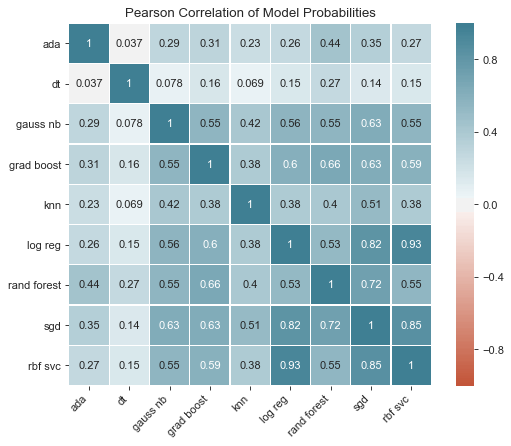

In [26]:
from vecstack import StackingTransformer
from sklearn.metrics import roc_auc_score

#Stacking
stack_l1_models = [
    ("ada", ada.best_estimator_), #
    ("dt", tree.best_estimator_),
    ("gauss nb", gauss_nb),
    ("grad boost", grad_boost.best_estimator_), #
    ("knn", knn.best_estimator_),
    ("log reg", log_reg),
    ("rand forest", rf.best_estimator_), #
    ("sgd", sgd.best_estimator_),
    ("rbf svc", rbf_svc.best_estimator_) #
]
l1_model_names = [x[0] for x in stack_l1_models]
stack = StackingTransformer(stack_l1_models, n_folds=5, needs_proba=True, regression=False, verbose=1, random_state=123)
stack.fit(X_train_df, y_train)
X_stack_train = stack.transform(X_train_df)[:,0::2]
#stack.transform() provides pobabilities for each target class
#for binary classification, only one probability is needed
#therefore, keep only odd columns
X_stack_train_df = pd.DataFrame(X_stack_train)
X_stack_train_df.columns = l1_model_names

model_corr = X_stack_train_df.corr()
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
ax = sns.heatmap(model_corr, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), square=True, linewidths=0.1, linecolor='white', annot=True, cbar=True)
###########################
#the following lines fix a bug in seaborn heatmaps
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
###########################
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.title("Pearson Correlation of Model Probabilities")
plt.savefig(os.path.join(data_path, "Base-Model-Corr.png"), dpi=100)
plt.show()

In [27]:
#Level 2 Stack: ADA Boost
ada_param_grid = {
    "base_estimator__min_impurity_decrease": np.logspace(-3, -2, 3, base=10),
    "base_estimator__criterion" : ["gini"], #"entropy"
    "base_estimator__splitter" :   ["random"], #"best"
    "n_estimators": [int(x) for x in np.linspace(100, 500, 11)]
}
ada_tree_clf = DecisionTreeClassifier(random_state=123)
ada_clf = AdaBoostClassifier(base_estimator = ada_tree_clf)
stack_l2_ada = GridSearchCV(ada_clf, param_grid=ada_param_grid, cv = 5, verbose=1, n_jobs = -1, scoring="roc_auc")
stack_l2_ada.fit(X_stack_train, y_train)
score_df = add_score(score_df, stack_l2_ada.best_score_, "Ensemble - Stack with ADA")

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 165 out of 165 | elapsed:   21.3s finished


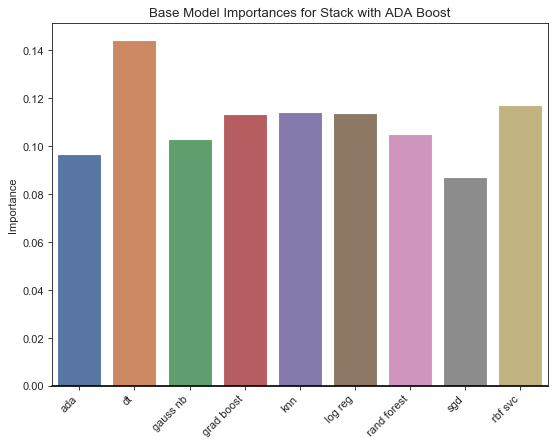

In [28]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
ax = sns.barplot(l1_model_names, stack_l2_ada.best_estimator_.feature_importances_, palette="deep")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Importance")
plt.title("Base Model Importances for Stack with ADA Boost")
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment("right")
plt.savefig(os.path.join(data_path, "ADA-Stack-Model-Importance.png"), dpi=100)
plt.show()

In [29]:
#Stack Level 2: Random Forest
rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 6)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(2, 20, num = 10)],
    'min_samples_split':  [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 100, num = 9)]
}

rf_clf = RandomForestClassifier(bootstrap=True, random_state=123)
stack_l2_rf = RandomizedSearchCV(rf_clf, param_distributions=rf_param_grid, n_iter=100, cv = 5, verbose=2, random_state=123, n_jobs = -1, scoring="roc_auc")
stack_l2_rf.fit(X_stack_train, y_train)
score_df = add_score(score_df, stack_l2_rf.best_score_, "Ensemble - Stack with RF")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.5s finished


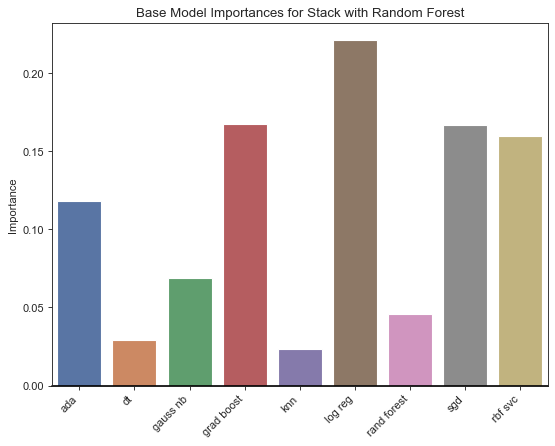

In [30]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
ax = sns.barplot(l1_model_names, stack_l2_rf.best_estimator_.feature_importances_, palette="deep")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Importance")
plt.title("Base Model Importances for Stack with Random Forest")
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment("right")
plt.savefig(os.path.join(data_path, "RF-Stack-Model-Importance.png"), dpi=100)
plt.show()

In [31]:
#Stacking with most important RF features
stack_l1_models_rf2 = [
    ("grad boost", grad_boost.best_estimator_),
    ("log reg", log_reg),
    ("sgd", sgd.best_estimator_)
]
l1_model_names_rf2 = [x[0] for x in stack_l1_models_rf2]
stack_rf2 = StackingTransformer(stack_l1_models_rf2, n_folds=5, needs_proba=True, regression=False, verbose=1, random_state=123)
stack_rf2.fit(X_train_df, y_train)
X_stack_train_rf2 = stack_rf2.transform(X_train_df)[:,0::2]
X_stack_train_df_rf2 = pd.DataFrame(X_stack_train_rf2)
X_stack_train_df_rf2.columns = l1_model_names_rf2

#Stack Level 2: Random Forest 2
stack_l2_rf2 = RandomizedSearchCV(rf_clf, param_distributions=rf_param_grid, n_iter=100, cv = 5, verbose=2, random_state=123, n_jobs = -1, scoring="roc_auc")
stack_l2_rf2.fit(X_stack_train_rf2, y_train)
score_df = add_score(score_df, stack_l2_rf2.best_score_, "Ensemble - Stack with RF 2")

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [3]

estimator  0: [grad boost: GradientBoostingClassifier]
    MEAN:     [0.92833189] + [0.21628990]

estimator  1: [log reg: LogisticRegression]
    MEAN:     [0.74513148] + [0.19009830]

estimator  2: [sgd: SGDClassifier]
    MEAN:     [0.59276879] + [0.04013435]

Train set was detected.
Transforming...

estimator  0: [grad boost: GradientBoostingClassifier]
    DONE

estimator  1: [log reg: LogisticRegression]
    DONE

estimator  2: [sgd: SGDClassifier]
    DONE

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.3s finished


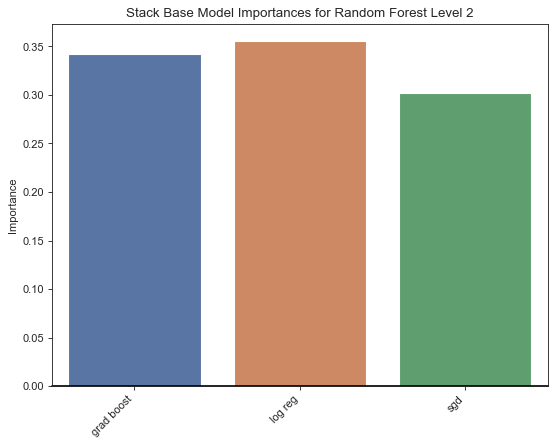

In [32]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
ax2 = sns.barplot(l1_model_names_rf2, stack_l2_rf2.best_estimator_.feature_importances_, palette="deep")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Importance")
plt.title("Stack Base Model Importances for Random Forest Level 2")
for item in ax2.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment("right")
plt.show()

The table provided below gives the mean ROC AUC score for all 5 folds for all the models generated in this notebook.  It shows that the ensemble technique of Soft Voting achieved the best score.  Reducing the number of base models from nine to three in the stacked random forest ensemble produced a small improvement in the score.  Logistic regression is shown to be marginally worse than the best ensemble techniques.  This is remarkable since it is one of the few models where no hypertuning was applied.

In [33]:
#write styled scores dataframe to an html file
score_html = score_df \
    .sort_values("Mean Score", ascending=False) \
    .rename(columns={"Alg Name": "Algorithm Name"}) \
    .reset_index() \
    .drop("index", axis=1) \
    .style \
    .hide_index() \
    .background_gradient(cmap="RdYlGn") \
    .set_precision(3) \
    .set_table_styles([dict(selector="th", props=[("border-bottom-style", "solid"),
                                                 ("border-bottom-color", "black"),
                                                 ("border-bottom-width", "2px"),
                                                 ("border-collapse", "collapse"),
                                                 ("text-align", "center")]),
                      dict(selector="td", props=[("border-bottom-style", "solid"),
                                                 ("border-bottom-color", "black"),
                                                 ("border-bottom-width", "1px"),
                                                 ("border-collapse", "collapse"),
                                                 ("text-align", "right")])]) \
    .render()
with open(os.path.join(data_path, "Score-Summ-Tbl.html"), "w") as f:
    f.write(score_html)

#write styled scores dataframe to notebook
score_df \
    .sort_values("Mean Score", ascending=False) \
    .rename(columns={"Alg Name": "Algorithm Name"}) \
    .reset_index() \
    .drop("index", axis=1) \
    .style \
    .hide_index() \
    .background_gradient(cmap="RdYlGn") \
    .set_precision(3) \
    .set_properties(**{'border-color': 'black',
                      'border-style': 'solid'}) \




Algorithm Name,Mean Score
Ensemble - Soft Voting,0.78
Ensemble - Stack with RF 2,0.777
Ensemble - Stack with RF,0.767
Ensemble - RF,0.759
Logistic Regression,0.759
SVC - RBF Kernel,0.758
Ensemble - Grad Boost,0.751
Stocastic Grad. Descent,0.751
Ensemble - ADA Boost,0.745
SVC - Linear Kernel,0.744


Since ROC AUC is the metric used for judging submissions, the plot below will show the ROC curve for nearly every model created.  Each curve is created by using 5 fold cross validation.  For each fold iteration, the FPR and TPR rates are evaluated, fitting on 80% of the training data and testing against 20% using the hypertuned parameters found previously. Each TPR value is then interpolated at predefined FPR values.  After this is completed for all 5 folds, the five interpolated TPR values are then averaged at each FPR value to yield the plotted curve.  This methodology was taken from scikit-learn's guidance: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

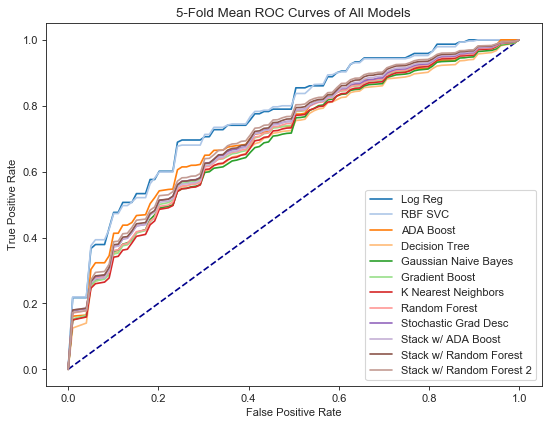

In [34]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
import matplotlib.cm as cmx
import matplotlib.colors as colors
from scipy import interp

#plot ROC curve for all models
roc_df = pd.DataFrame()
all_models = [
    log_reg, 
    #lin_svc,
    #poly_svc,
    rbf_svc.best_estimator_,
    ada.best_estimator_,
    tree.best_estimator_,
    gauss_nb,
    grad_boost.best_estimator_,
    knn.best_estimator_,
    rf.best_estimator_,
    sgd.best_estimator_,
    stack_l2_ada.best_estimator_,
    stack_l2_rf.best_estimator_,
    stack_l2_rf2.best_estimator_
]
all_model_names = [
    "Log Reg",
    #"Linear SVC",
    #"Polynomial SVC",
    "RBF SVC",
    "ADA Boost",
    "Decision Tree",
    "Gaussian Naive Bayes",
    "Gradient Boost",
    "K Nearest Neighbors",
    "Random Forest",
    "Stochastic Grad Desc",
    "Stack w/ ADA Boost",
    "Stack w/ Random Forest",
    "Stack w/ Random Forest 2"
]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor=None)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
cv = KFold(n_splits=5)
tprs = []
mean_fpr = np.linspace(0, 1, 100)
X_train = X_train_df.values
for model_ind in range(9):
    for train, test in cv.split(X_train_df, y_train):
        fold_fit = all_models[model_ind].fit(X_train[train], y_train[train])
        fold_probas = fold_fit.predict_proba(X_train[test])[:,1]
        fpr, tpr, _ = roc_curve(y_train[test], fold_probas, pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.plot(mean_fpr, mean_tpr, color=plt.cm.tab20(model_ind), label=all_model_names[model_ind])

for model_ind in [model_ind+1, model_ind+2]:
    for train, test in cv.split(X_stack_train_df, y_train):
        fold_fit = all_models[model_ind].fit(X_stack_train[train], y_train[train])
        fold_probas = fold_fit.predict_proba(X_stack_train[test])[:,1]
        fpr, tpr, _ = roc_curve(y_train[test], fold_probas, pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.plot(mean_fpr, mean_tpr, color=plt.cm.tab20(model_ind), label=all_model_names[model_ind])

X_stack_train_rf2 = X_stack_train_df_rf2.values
for train, test in cv.split(X_stack_train_df_rf2, y_train):
    fold_fit = all_models[model_ind+1].fit(X_stack_train_rf2[train], y_train[train])
    fold_probas = fold_fit.predict_proba(X_stack_train_rf2[test])[:,1]
    fpr, tpr, _ = roc_curve(y_train[test], fold_probas, pos_label=1)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.plot(mean_fpr, mean_tpr, color=plt.cm.tab20(model_ind+1), label=all_model_names[model_ind+1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5-Fold Mean ROC Curves of All Models')
plt.legend()
plt.savefig(os.path.join(data_path, "ROC-curves.png"), dpi=100)
plt.show()

## Conclusion
Fourteen models were generated in this analysis, eight of which were basic and six were ensembles based the eight.  The ensemble techniques provided a small improvement on the best basic models. The submission file will be created using the model with the highest score (Soft Voting Ensemble).

What could be done better?  Reading some of the notebooks and discussion threads on the Kaggle competition website, feature importance was examined using the ELI5 package, partial dependence andthe SHAP package.  All of these are defined in this Kaggle notebook: https://www.kaggle.com/mjbahmani/tutorial-on-ensemble-learning-don-t-overfit

Also, alternate metrics mentioned in the research section could be added to the model evaluation.

And lastly, evaluating distances between observations in hyperspace can be a good method of identifying patterns in target behavior.  While K nearest relies on euclidean distance, other measures of distance

In [38]:
#make submission dataframe with predictions column
y_test = voting.predict(test_df)
y_test_df = pd.DataFrame(y_test, dtype=np.int8)
y_test_df.columns = ["target"]

#make the index column match the required submission format
#index needs to be shifted from starting at 0 to starting at 250
y_test_df["index_shift"] = y_test_df.index
y_test_df["index_shift"] = y_test_df.index_shift.add(250)
y_test_df.set_index("index_shift", drop=True, append=False, inplace=True, verify_integrity=False)
y_test_df.index.names = ["id"]

#write the submission dataframe to csv
y_test_df.to_csv(os.path.join(data_path, "submit.csv"), index=True, header=True)